## Classificação de compostos químicos e métodos de interpretabilidade

Objetivo : classificação de compostos químicos baseada na sua capacidade de interagir com a proteína p53 (elemento importante na prevenção do desenvolvimento de tumores)
Dataset: TOX21

<b>NR-AR, NR-ER, NR-AhR, NR-PPAR-gamma</b>: Esses atributos rep-
resentam a atividade de receptores nucleares, como o receptor de andrógeno
(AR), estrogênio (ER), hidrocarboneto aromático (AhR) e receptor ativado
por proliferadores de peroxissoma-gama (PPAR-gama). Esses receptores es-
tão envolvidos em diversos processos celulares, incluindo crescimento celular,
diferenciação e apoptose, os quais também são regulados pela proteína p53.
Compostos que modulam a atividade desses receptores podem afetar indire-
tamente as vias mediadas por p53

<b>NR-Aromatase</b>: Aromatase é uma enzima envolvida na biossíntese de es-
trogênio. Os receptores de estrogênio (ERs) desempenham um papel na
regulação da expressão e atividade da p53. Compostos que influenciam a
atividade da aromatase podem impactar os níveis de estrogênio, afetando
potencialmente as respostas mediadas por p53.

<b>SR-p53</b>: Este atributo representa a atividade da própria proteína p53.

<b>SR-ARE</b>, SR-ATAD5, SR-HSE, SR-MMP: Esses atributos representam a atividade de receptores xenobióticos ou vias moleculares relacionadas
à resposta celular ao estresse, reparo de DNA e metaloproteinases da matriz.
Embora essas vias possam não interagir diretamente com a p53, elas podem
se intersectar com as vias mediadas por p53, influenciando as respostas celu-
lares ao estresse, danos ao DNA e tumorigênese.

<b>mol_id</b>: Este atributo representa um identificador único atribuído a cada
composto no conjunto de dados. Ele serve como uma referência ou chave para
distinguir um composto de outro dentro do conjunto de dados. O mol_id não
fornece informações sobre a atividade biológica do composto, mas é essencial
para a organização e gestão dos dados.

<b>smiles</b>: SMILES significa Simplified Molecular Input Line Entry System, que
é um sistema de notação usado para representar a estrutura de moléculas
químicas como strings de texto. As strings SMILES codificam o arranjo
de átomos e ligações em uma molécula, fornecendo uma forma compacta e
padronizada de descrever estruturas químicas

In [21]:
%load_ext autoreload
%autoreload 2
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import torch.nn.functional as F
import os
from cairosvg import svg2png, svg2ps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
ds = pd.read_csv('data/tox21.csv')

**Data Pre-processing**

In [23]:
ds.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


In [24]:
ds.shape

(7831, 14)

In [25]:
ds.dropna(subset=['SR-p53'],inplace=True)
#ds["SR-p53"].fillna(1.0, inplace=True)

In [26]:
ds.isnull().sum()

NR-AR             110
NR-AR-LBD         394
NR-AhR            694
NR-Aromatase     1203
NR-ER             859
NR-ER-LBD         258
NR-PPAR-gamma     592
SR-ARE           1592
SR-ATAD5          150
SR-HSE           1055
SR-MMP           1334
SR-p53              0
mol_id              0
smiles              0
dtype: int64

Como visto acima é notavel que este dataset contém uma quantidade substancial de valores nulos. Sendo assim, o grupo enfrenta o dilema de como tratar destes valores. Considerando que estes valores são representativos da presença de um certo recetor num composto quimico é possivel assumir que a falta de representação pode significar a falta deste recetor sendo assim possivel substituir o valor nulo por um 0. 

In [27]:
ds['SR-p53'].value_counts()

SR-p53
0.0    6351
1.0     423
Name: count, dtype: int64

In [28]:
ds_true = ds[ds['SR-p53'] == 1]
ds_false = ds[ds['SR-p53'] == 0]

ds_false = ds_false.sample(ds_true.shape[0])
ds_true.shape, ds_false.shape 

((423, 14), (423, 14))

In [29]:
ds = pd.concat([ds_true, ds_false])
ds.shape

(846, 14)

A coluna mol_id representa um id usado pela comunidade cientifica para o reconhecimento de um composto quimico por isso não sendo relevante nesta pesquisa. 

In [30]:
print(ds['mol_id'].duplicated().sum())

0


In [31]:
ds.drop('mol_id', axis=1, inplace=True)

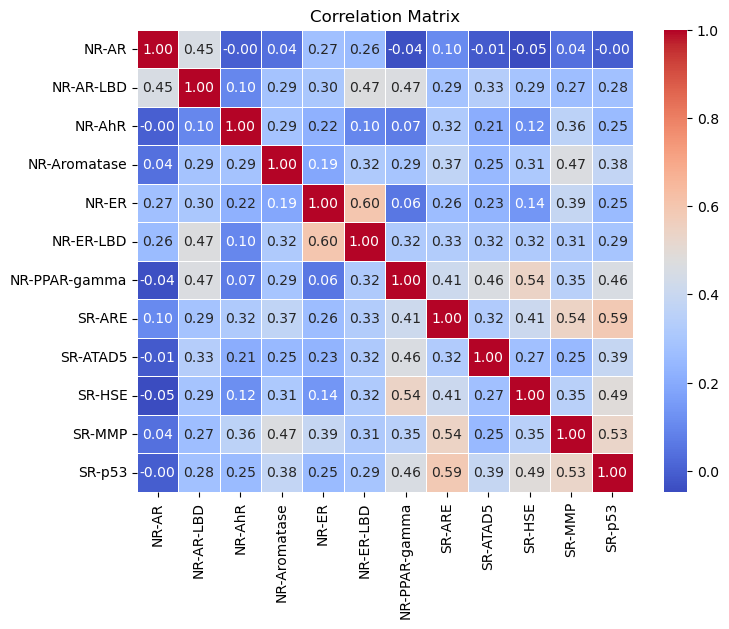

In [32]:
ds1 = ds.drop(['smiles'], axis=1)
correlation = ds1.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [33]:
mols = pd.DataFrame()
mols["smiles"] = ds['smiles'].apply(Chem.MolFromSmiles)

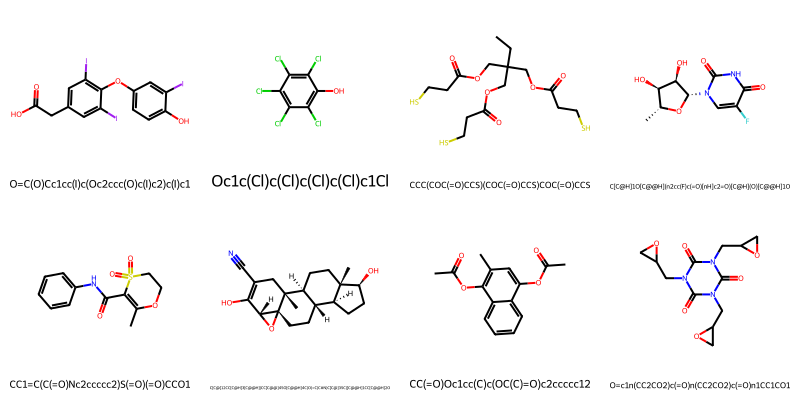

In [34]:
Draw.MolsToGridImage(mols['smiles'][:8],molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in mols['smiles'][:8]])

In [35]:
ds.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,smiles
7,0.0,NaN,0.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,0.0,1.0,O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1
33,0.0,NaN,1.0,NaN,NaN,0.0,NaN,1.0,0.0,0.0,1.0,1.0,Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,CCC(COC(=O)CCS)(COC(=O)CCS)COC(=O)CCS
77,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,1.0,C[C@H]1O[C@@H](n2cc(F)c(=O)[nH]c2=O)[C@H](O)[C...
116,0.0,0.0,0.0,NaN,NaN,0.0,NaN,1.0,0.0,NaN,NaN,1.0,CC1=C(C(=O)Nc2ccccc2)S(=O)(=O)CCO1


In [36]:
def getAtrValue(atr,smiles):
    return ds.loc[ds['smiles'] == smiles, atr].iloc[0]

In [37]:
def notactive(n):
    if(n==0.0): return True
    else: return False

def isactive(n):
    if(n==1.0): return True
    else: return False

active = filter(isactive,ds['SR-p53'])
inactive = filter(notactive,ds['SR-p53'])
print("Existem "+str(len(list(active)))+ " compostos químicos reativos à SR-p53.")
print("Existem "+str(len(list(inactive)))+ " compostos químicos não reativos à SR-p53.")

Existem 423 compostos químicos reativos à SR-p53.
Existem 423 compostos químicos não reativos à SR-p53.


**Get default device as CPU or cuda(GPU) based on availability**

In [38]:
#setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

#force cpu
#device = torch.device("cpu")
print('Using device:', device)

NVIDIA GeForce RTX 3050 Ti Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Using device: cuda


**Converter cada uma das moléculas num grafo**

A representação de um grafo pode ser feita convertendo uma molécula (rdkit.chem.mol) para uma instância torch_geometric.data.Data do Pytorch Geometric.

- Podemos utilizar as propriedades de cada molécula do dataset, juntamente com outras fornecidas pela biblioteca rdkit.chem.mol.
- Iterar pelos átomos e adicioná-los num vetor que será convertido para um tensor PyTorch.
- Depois iterar pelas ligações, sendo que as extremidades vão para a lista edge_index, enquanto que os vetores das ligações vão para a edge_attr.
- Após a conversão destas listas para tensores e de ordenar os índices temos os dados necessários para criar a instância Data.

<a href="https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/smiles.html">https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/smiles.html</a>

In [39]:
atom_characteristics = {
    #RDKIT.CHEM.MOL CHARACTERISTICS
    'atomic_num': list(range(0, 119)),
    'chirality': ['CHI_UNSPECIFIED','CHI_TETRAHEDRAL_CW','CHI_TETRAHEDRAL_CCW','CHI_OTHER','CHI_TETRAHEDRAL','CHI_ALLENE','CHI_SQUAREPLANAR','CHI_TRIGONALBIPYRAMIDAL','CHI_OCTAHEDRAL'],
    'degree': list(range(0, 11)),
    'formal_charge': list(range(-5, 7)),
    'num_hs': list(range(0, 9)),
    'num_radical_electrons': list(range(0, 5)),
    'hybridization': ['UNSPECIFIED','S','SP','SP2','SP3','SP3D','SP3D2','OTHER'],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True],
}

bond_characteristics= {
    #RDKIT.CHEM.MOL CHARACTERISTICS
    'bond_type': ['UNSPECIFIED','SINGLE','DOUBLE','TRIPLE','QUADRUPLE','QUINTUPLE','HEXTUPLE','ONEANDAHALF','TWOANDAHALF','THREEANDAHALF','FOURANDAHALF','FIVEANDAHALF','AROMATIC','IONIC','HYDROGEN','THREECENTER','DATIVEONE','DATIVE','DATIVEL','DATIVER','OTHER','ZERO'],
    'stereo': ['STEREONONE','STEREOANY','STEREOZ','STEREOE','STEREOCIS','STEREOTRANS'],
    'is_conjugated': [False, True],
}

função molecule_to_graph(strsmiles:string, label:double->SR-p53,mol:RDkit.Chem.Mol)

In [40]:
from torch_geometric.data import Data

def molecule_to_graph(strsmiles,label,mol):

    xs = []
    additional_properties = []

    for atom in mol.GetAtoms():

        x = []
        x.append(atom_characteristics['atomic_num'].index(atom.GetAtomicNum()))
        x.append(atom_characteristics['chirality'].index(str(atom.GetChiralTag())))
        x.append(atom_characteristics['degree'].index(atom.GetTotalDegree()))
        x.append(atom_characteristics['formal_charge'].index(atom.GetFormalCharge()))
        x.append(atom_characteristics['num_hs'].index(atom.GetTotalNumHs()))
        x.append(atom_characteristics['num_radical_electrons'].index(atom.GetNumRadicalElectrons()))
        x.append(atom_characteristics['hybridization'].index(str(atom.GetHybridization())))
        x.append(atom_characteristics['is_aromatic'].index(atom.GetIsAromatic()))
        x.append(atom_characteristics['is_in_ring'].index(atom.IsInRing()))

        xs.append(x)

    x = torch.tensor(xs, dtype=torch.float).view(-1, 9)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e=[
            bond_characteristics['bond_type'].index(str(bond.GetBondType())),
            bond_characteristics['stereo'].index(str(bond.GetStereo())),
            bond_characteristics['is_conjugated'].index(bond.GetIsConjugated())
            ]
        e += [0] * (32 - len(e))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float).view(-1, 1)

    label = torch.tensor(label, dtype=torch.long)

    if edge_index.numel() > 0:
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y = label, smiles=strsmiles)

    additional_properties.append(getAtrValue("NR-AR",data.smiles))
    additional_properties.append(getAtrValue("NR-AR-LBD",data.smiles))
    additional_properties.append(getAtrValue("NR-AhR",data.smiles))
    additional_properties.append(getAtrValue("NR-Aromatase",data.smiles))
    additional_properties.append(getAtrValue("NR-ER",data.smiles))
    additional_properties.append(getAtrValue("NR-ER-LBD",data.smiles))
    additional_properties.append(getAtrValue("NR-PPAR-gamma",data.smiles))
    additional_properties.append(getAtrValue("SR-ARE",data.smiles))
    additional_properties.append(getAtrValue("SR-ATAD5",data.smiles))
    additional_properties.append(getAtrValue("SR-HSE",data.smiles))
    additional_properties.append(getAtrValue("SR-MMP",data.smiles))
    additional_properties = torch.tensor(additional_properties, dtype=torch.long).view(-1, 11)

    data.additionalproperties = additional_properties
    return data  

In [93]:
molecule_to_graph(ds.iloc[0]['smiles'], ds.iloc[0]['SR-p53'], Chem.MolFromSmiles(ds.iloc[0]['smiles']))

RuntimeError: value cannot be converted to type int64 without overflow

In [89]:
process_func = lambda mols: molecule_to_graph(mols['smiles'], mols['SR-p53'], Chem.MolFromSmiles(mols['smiles']))
list_data = list(map(process_func,ds.iloc))
list_data[0]

RuntimeError: value cannot be converted to type int64 without overflow

**Create a train and test set**

In [ ]:
import random

random.seed(123)
random.shuffle(list_data)

size = int(len(list_data) * 0.7)

train_dataset = list_data[:size]
test_dataset = list_data[size:]

NameError: name 'list_data' is not defined

**Create Dataloader**

In [ ]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

c:\Users\joaop\miniconda3\envs\apenv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
import models
from torchinfo import summary
    
gcn_model = models.GCNModel()
print(summary(gcn_model,verbose=1))

Layer (type:depth-idx)                   Param #
GCNModel                                 --
├─GCNConv: 1-1                           8
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       72
├─GCNConv: 1-2                           16
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       128
├─GCNConv: 1-3                           32
│    └─SumAggregation: 2-5               --
│    └─Linear: 2-6                       512
├─Linear: 1-4                            66
Total params: 834
Trainable params: 834
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
GCNModel                                 --
├─GCNConv: 1-1                           8
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       72
├─GCNConv: 1-2                           16
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       128
├─GCNConv: 1-3                           32
│

In [ ]:
gcn_model.to(device)

GCNModel(
  (conv1): GCNConv(9, 8)
  (conv2): GCNConv(8, 16)
  (conv3): GCNConv(16, 32)
  (linear): Linear(in_features=32, out_features=2, bias=True)
)

**Train Model**

In [ ]:
def train(trainloader,optimizer,loss_func):
    running_loss  = 0.0
    running_corrects  = 0.0
    for data in trainloader:
            
        inputs = data.x.to(device)
        labels = data.y.to(device)
        outputs = gcn_model(inputs, data.edge_index,data.edge_attr,batch=data.batch)
        loss = loss_func(outputs, labels)
        # limpar gradientes
        optimizer.zero_grad() 
        # calculo dos gradientes
        loss.backward()
        # atuazlizar os pesos
        optimizer.step()
            
        running_loss += loss.detach() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    return (running_loss,running_corrects)

**Test Model**

In [ ]:
def test(valloader,optimizer,loss_func):
   running_loss  = 0.0
   running_corrects  = 0.0
   for data in valloader:
      inputs = data.x.to(device)
      labels = data.y.to(device)
      outputs =  gcn_model(inputs,data.edge_index,data.edge_attr,batch=data.batch)
      loss = loss_func(outputs, labels)
      running_loss += loss.detach() * inputs.size(0)
      _, preds = torch.max(outputs, 1)
      running_corrects += torch.sum(preds == labels.data)
   return (running_loss,running_corrects)

**Compute epochs for train and test**

In [ ]:
from livelossplot import PlotLosses

def computepochs(trainloader,valloader, model, optimizer, loss_func,epochs):
    liveloss = PlotLosses()
    for epoch in range(epochs):
        logs = {}
        model.train()

        running_loss,running_corrects = train(trainloader,optimizer,loss_func)
        
        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_acc = running_corrects.float() / len(trainloader.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()

        model.eval()
            
        running_loss,running_corrects = test(valloader,optimizer,loss_func)
        
        epoch_loss = running_loss / len(valloader.dataset)
        epoch_acc = running_corrects.float() / len(valloader.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()

**Train and test**

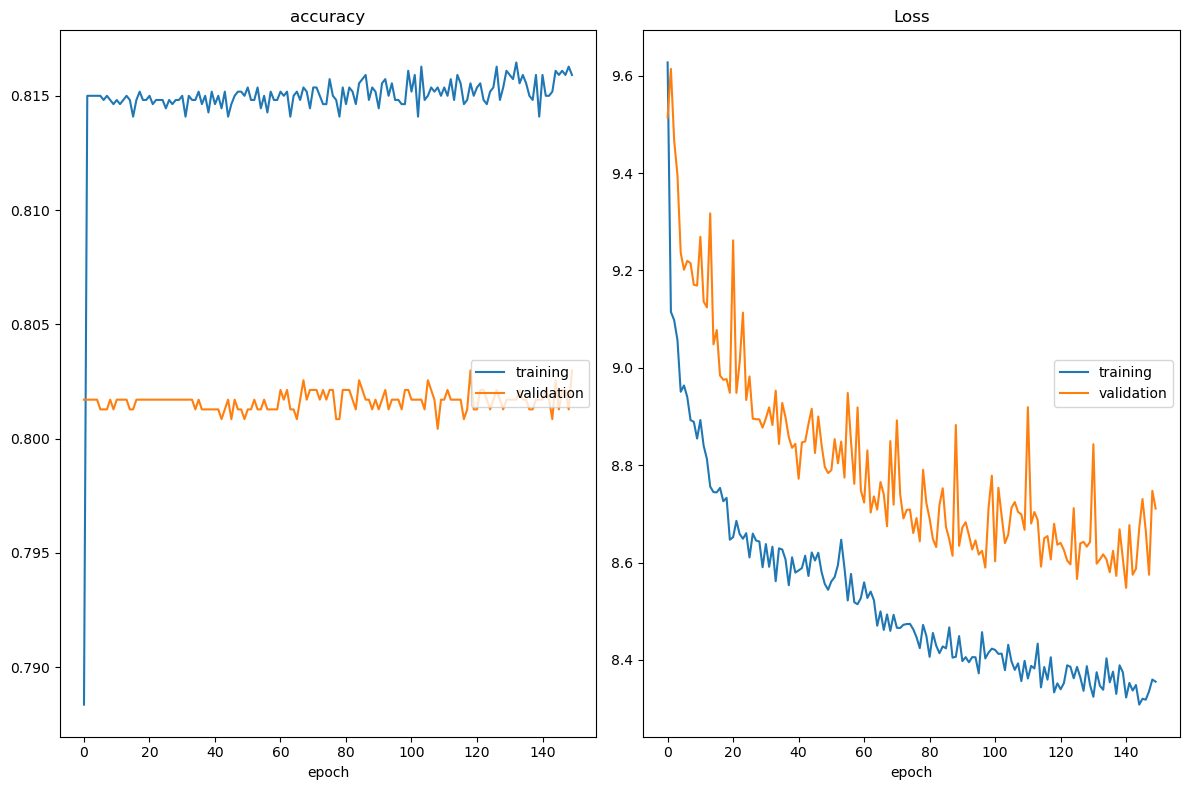

accuracy
	training         	 (min:    0.788, max:    0.816, cur:    0.816)
	validation       	 (min:    0.800, max:    0.803, cur:    0.803)
Loss
	training         	 (min:    8.308, max:    9.627, cur:    8.355)
	validation       	 (min:    8.548, max:    9.614, cur:    8.711)


c:\Users\joaop\miniconda3\envs\apenv\lib\site-packages\torch\utils\hooks.py:87: UserWarning: backward hook <bound method GCNModel.activations_hook of GCNModel(
  (conv1): GCNConv(9, 8)
  (conv2): GCNConv(8, 16)
  (conv3): GCNConv(16, 32)
  (linear): Linear(in_features=32, out_features=2, bias=True)
)> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn(f"backward hook {repr(hook)} on tensor will not be "


In [ ]:
from livelossplot import PlotLosses
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from os.path import exists


epochs = 150
optimizer = Adam(gcn_model.parameters(),lr=0.001)
loss_func = CrossEntropyLoss()
print(gcn_model)
train_accs = []
test_accs = []


file_exists = exists('gcnmodel.pth')
liveloss = PlotLosses()
# nao sei se isto resulta? apenas para carregar os pesos e não estar a treinar tudo outra vez
if(file_exists==False):
    computepochs(train_loader,test_loader,gcn_model,optimizer,loss_func,epochs)
    torch.save(gcn_model,'gcnmodel.pth')
else:
    gcn_model= torch.load('gcnmodel.pth')


In [ ]:
listoflistsmiles = []
def compute_feature_importance(loader, model, loss_func):
    i=0
    feature_importance = torch.zeros(model.input.size(1))
    model.eval()
    for data in loader:
        inputs = data.x.to(device)
        labels = data.y.to(device)
        inputs.requires_grad = True 

        outputs = model(inputs, data.edge_index,data.edge_attr,batch=data.batch)
        loss = loss_func(outputs, labels)
        listoflistsmiles.append(data.smiles)
        loss.backward()

        i += 1
        feature_importance += torch.abs(inputs.grad).sum(dim=0)

    feature_importance /= len(loader.dataset)
    return feature_importance


Um maior valor absoluto dos gradientes indica um maior impacto para a previsão final da rede neuronal.

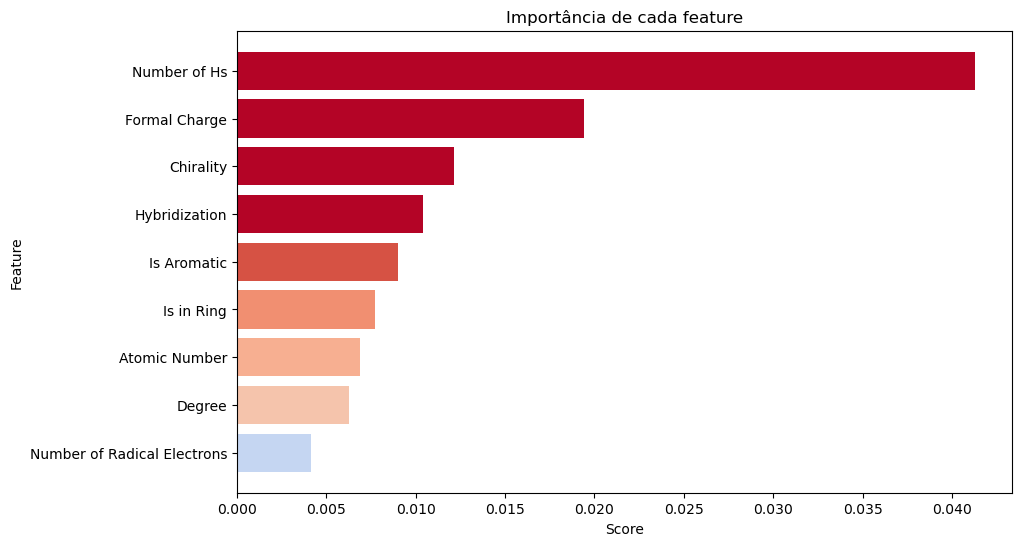

In [ ]:
import matplotlib.pyplot as plt

feature_importance = compute_feature_importance(test_loader, gcn_model, loss_func)

feature_names = ['Atomic Number', 'Chirality', 'Degree', 'Formal Charge','Number of Hs', 'Number of Radical Electrons', 'Hybridization', 'Is Aromatic', 'Is in Ring']
sorted_indices = feature_importance.argsort(descending=True)
sorted_features = [feature_names[i-1] for i in sorted_indices]
sorted_scores = feature_importance[sorted_indices]
cmap = plt.get_cmap('coolwarm')

barcolors = [cmap(score*100) for score in sorted_scores]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_scores, color=barcolors)
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Importância de cada feature')
plt.gca().invert_yaxis() 
plt.show()


#### Recolher e guardar os gradientes para cada átomo

In [ ]:
nr=0
atoms_gradients= []
for data in test_loader:
    optimizer.zero_grad()
    inputs = data.x.to(device)
    labels = data.y.to(device)
    inputs.requires_grad = True 

    outputs = gcn_model(inputs, data.edge_index,data.edge_attr,batch=data.batch)
    loss = loss_func(outputs, labels)
    loss.backward()
    # recolher gradientes de cada data
    atom_gradients = gcn_model.input.grad
    # guardar gradientes para cada átomo
    batch_size = atom_gradients.size(0)
    for i in range(batch_size):
        atom_grad = atom_gradients[i,:]
        node_saliency = torch.norm(F.relu(atom_grad)).item()
        atoms_gradients.append(atom_grad)
        nr+=1

#### Guardar imagens de moléculas com os átomos com maiores gradient scores destacados. Pasta: /interpretation/.

In [ ]:
import re
def save_highlighted(smiles,weights):
    m = Chem.MolFromSmiles(smiles)
    m.__sssAtoms = weights
    m
    img = Draw.MolToImage(m, kekulize=True, wedgeBonds=True, highlightAtoms=weights)
    directory = "atom_interpretation"
    smiles = re.sub(r'[\\\/\+\=\[\]\-\#]', '_', smiles)
    if not os.path.exists(directory):
        os.makedirs(directory)

    img.save(os.path.join(directory, str(smiles)+".png"))

#### Ordenar e agregar os gradientes para a previsão da interação com o gene p53 de cada um dos átomos das moléculas

In [ ]:
nrmoleculas = 0
for data in test_loader:
    natom=0
    for smile in data.smiles:
        nratomos = len(list(Chem.MolFromSmiles(smile).GetAtoms()))
        final = natom + nratomos
        print(smile)
        mean_gradients=[]
        j=0
        for a in range(natom,final):
            mean_gradients.append((j,torch.mean(atoms_gradients[a]).item()))
            j+=1
        print("<<<<<<")
        sorted_gradients = sorted(mean_gradients, key = lambda x : x[0],reverse=True)
        highlighted_atoms = []
        if(len(sorted_gradients)>=5):
            for i in range(0,5):
                highlighted_atoms.append(sorted_gradients[i][0])
        elif(len(sorted_gradients)>=1):
            for i in range(0,1):
                highlighted_atoms.append(sorted_gradients[i][0])
        save_highlighted(smile,highlighted_atoms)
        natom += nratomos+1
        nrmoleculas += 1
        if(nrmoleculas==5):break
    break

CC=CC(=O)N(CC)c1ccccc1C
<<<<<<
CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(C[N+]3(C)CCCC3)CS[C@H]12)c1csc(N)n1
<<<<<<
N[C@@H](Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1)C(=O)O
<<<<<<
CCOc1ccccc1O[C@H](c1ccccc1)[C@H]1CNCCO1
<<<<<<
CC1(C)O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]5(C)[C@H]4[C@@H](O)C[C@]3(C)[C@]2(C(=O)CO)O1
<<<<<<


In [ ]:
def calculate_edge_scores(edge_attr_grads):
    edge_grad_norms = torch.norm(edge_attr_grads, dim=1)
    edge_scores = (edge_grad_norms - edge_grad_norms.min()) / (edge_grad_norms.max() - edge_grad_norms.min())
    return edge_scores

In [ ]:
def visualize_molecule_with_edge_scores(smiles, edge_scores):
    mol = Chem.MolFromSmiles(smiles)
    d = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(300, 300)

    bond_colors = {}
    for i, score in enumerate(edge_scores):
        bond_colors[i] = cmap(score)

    Chem.Draw.rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=[], highlightBonds=list(range(mol.GetNumBonds())),highlightBondColors=bond_colors)
    directory = "edge_interpretation"
    smiles = re.sub(r'[\\\/\+\=\[\]\-\#]', '_', smiles)
    if not os.path.exists(directory):
        os.makedirs(directory)
    d.FinishDrawing()
    d.WriteDrawingText(os.path.join(directory, str(smiles)+".png"))

In [ ]:
gcn_model.my_grads[0]

tensor([ 6.5137e-04,  2.5208e-04,  3.8939e-05, -3.5356e-04,  2.5236e-04,
         4.1427e-04, -2.4702e-04,  3.5478e-04, -3.1810e-07, -2.3810e-04,
         1.2482e-05,  4.1057e-04, -2.4664e-04,  4.0899e-04,  6.0903e-06,
         1.2164e-04,  1.0848e-04, -6.3633e-04,  1.2202e-05,  1.2882e-05,
         8.7795e-05,  5.1580e-04, -5.6790e-04,  1.3610e-04,  3.8966e-04,
        -4.3505e-04, -3.1733e-05,  4.1146e-04, -9.0283e-04, -2.7972e-05,
        -1.7379e-05, -2.0702e-04])

In [ ]:
edge_grads = []
for data in test_loader:
    inputs = data.x.to(device)
    labels = data.y.to(device)
    optimizer.zero_grad()

    outputs = gcn_model(inputs, data.edge_index, data.edge_attr, batch=data.batch)
    loss = loss_func(outputs, labels)
    loss.backward()
    # Aceder aos gradientes dos edges
    edge_grads.append(gcn_model.my_grads[:, :data.edge_attr.size(0)])

In [ ]:
scores = calculate_edge_scores(edge_grads[0])

In [ ]:
sum=0
for data in test_loader:
    nrbond = 0
    for smile in data.smiles:
        nrbonds = len(list(Chem.MolFromSmiles(smile).GetBonds()))
        final = nrbond + nrbonds
        if(len(scores[nrbond:final])>0):
            visualize_molecule_with_edge_scores(smile,scores[nrbond:final])
        nrbond += nrbonds+1
    break


### Explainability for node classification on graph using Explainer and CaptumExplainer

In [ ]:
from torch_geometric.explain import Explainer, CaptumExplainer

explainer = Explainer(
    gcn_model,  
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config = dict(
        mode='binary_classification',
        task_level="graph",
        return_type="probs",
    ),
)

In [ ]:
mydata = None
explanations = []
for data in test_loader:
    mydata = data
    explanation = explainer(mydata.x, mydata.edge_index, edge_attr=mydata.edge_attr, batch=mydata.batch)
    explanations.append(explanation)

#### Visualize feature importance of random sample

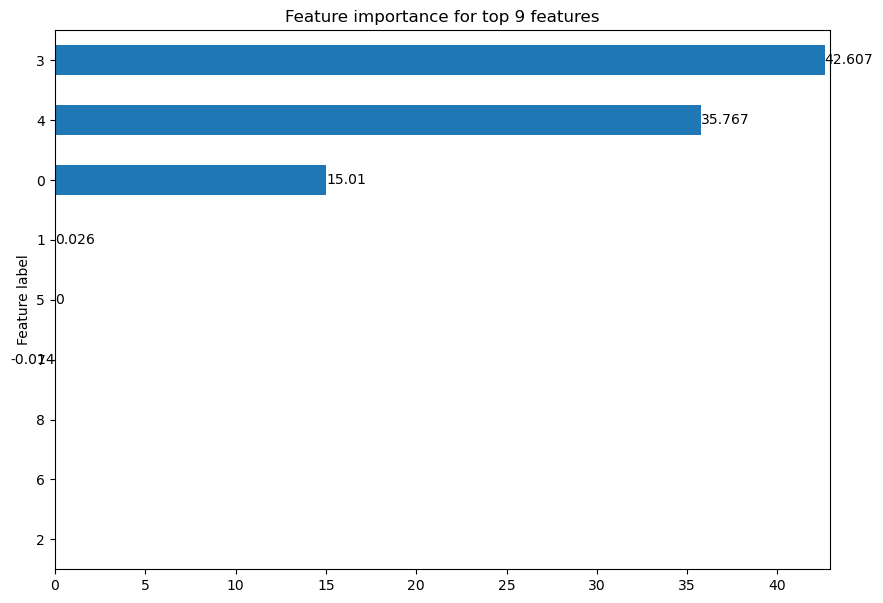

In [ ]:
import random
sample = random.randrange(0,74)
explanations[sample].visualize_feature_importance(top_k=10)

Graph visualization

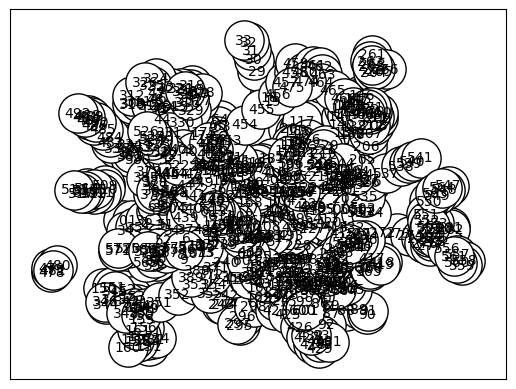

In [ ]:
explanations[sample].visualize_graph()